In [2]:
from __future__ import division, print_function, unicode_literals
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
from sklearn.metrics import precision_recall_curve

from utils.metrics import threshold_at_completeness_of, threshold_at_purity_of
from utils.bootstrap import (
    kde_purity,
    kde_completeness,
    get_stellar_fraction,
    confidence_band,
    get_log_density
)

plt.rc('legend', fontsize=10)

In [7]:
df = pd.read_csv("sdss_test.csv")
g_r = df["dered_g"].values - df["dered_r"].values

In [4]:
morph_true, morph_pred = np.loadtxt('sdss_tpc.2.mlz', unpack=True, usecols=(0, 2))

In [5]:
phot_true, phot_pred = np.loadtxt('sdss_tpc.3.mlz', unpack=True, usecols=(0, 2))

In [9]:
y_true = np.load("sdss_test_labels.npy")
cnn_pred = np.load("sdss_convnet_pred.npy")

y_true = (y_true + 1) / 2 # make galaxy=0 and star=1

In [10]:
mask = ((g_r > -10) & (g_r < 10))
g_r, y_true, cnn_pred, phot_pred, morph_pred = map(
    lambda x: x[mask],
    [g_r, y_true, cnn_pred, phot_pred, morph_pred]
)

In [11]:
bins = np.arange(-0.75, 2.75, 0.05)

In [38]:
stars_frac_med, stars_frac_lower, stars_frac_upper = confidence_band(
    get_stellar_fraction, y_true, y_true, g_r, bins=bins, n_boots=100)

Bootstrapping...
10 percent complete...
20 percent complete...
30 percent complete...
40 percent complete...
50 percent complete...
60 percent complete...
70 percent complete...
80 percent complete...
90 percent complete...
Complete.


In [39]:
cnn_cut, _ = threshold_at_completeness_of(1 - y_true, 1 - cnn_pred, 0.96)

cnn_g_med, cnn_g_lower, cnn_g_upper = confidence_band(
    kde_purity, 1 - y_true, 1- cnn_pred, g_r, bins=bins, p_cut=cnn_cut, n_boots=100)

Bootstrapping...
10 percent complete...
20 percent complete...
30 percent complete...
40 percent complete...
50 percent complete...
60 percent complete...
70 percent complete...
80 percent complete...
90 percent complete...
Complete.


In [40]:
phot_p_cut, _ = threshold_at_completeness_of(1 - y_true, 1 - phot_pred, 0.96)

phot_g_med, phot_g_lower, phot_g_upper = confidence_band(
    kde_purity, 1 - y_true, 1 - phot_pred, g_r, bins=bins, p_cut=phot_p_cut, n_boots=100)

Bootstrapping...
10 percent complete...
20 percent complete...
30 percent complete...
40 percent complete...
50 percent complete...
60 percent complete...
70 percent complete...
80 percent complete...
90 percent complete...
Complete.


In [41]:
morph_p_cut, _ = threshold_at_completeness_of(1 - y_true, 1 - morph_pred, 0.96)

morph_g_med, morph_g_lower, morph_g_upper = confidence_band(
    kde_purity, 1 - y_true, 1 - morph_pred, g_r, bins=bins, p_cut=morph_p_cut, n_boots=1000)

Bootstrapping...
10 percent complete...
20 percent complete...
30 percent complete...
40 percent complete...
50 percent complete...
60 percent complete...
70 percent complete...
80 percent complete...
90 percent complete...
Complete.


In [42]:
cnn_p_cut = 0.60463386

cnn_s_med, cnn_s_lower, cnn_s_upper = confidence_band(
    kde_completeness, y_true, cnn_pred, g_r, bins=bins, p_cut=cnn_p_cut, n_boots=1000)

Bootstrapping...
10 percent complete...
20 percent complete...
30 percent complete...
40 percent complete...
50 percent complete...
60 percent complete...
70 percent complete...
80 percent complete...
90 percent complete...
Complete.


In [43]:
phot_p_cut, _ = threshold_at_purity_of(y_true, phot_pred, 0.97)

phot_s_med, phot_s_lower, phot_s_upper = confidence_band(
    kde_completeness, y_true, phot_pred, g_r, bins=bins, p_cut=phot_p_cut, n_boots=1000)

Bootstrapping...
10 percent complete...
20 percent complete...
30 percent complete...
40 percent complete...
50 percent complete...
60 percent complete...
70 percent complete...
80 percent complete...
90 percent complete...
Complete.


In [44]:
morph_p_cut, _ = threshold_at_purity_of(y_true, morph_pred, 0.97)

morph_s_med, morph_s_lower, morph_s_upper = confidence_band(
    kde_completeness, y_true, morph_pred, g_r, bins=bins, p_cut=morph_p_cut, n_boots=1000)

Bootstrapping...
10 percent complete...
20 percent complete...
30 percent complete...
40 percent complete...
50 percent complete...
60 percent complete...
70 percent complete...
80 percent complete...
90 percent complete...
Complete.


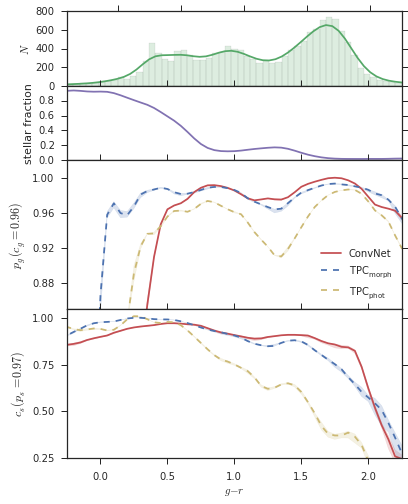

In [47]:
alpha = 0.2

p = sns.color_palette()
sns.set(style="ticks")

fig = plt.figure(figsize=(6, 8))

ax0 = plt.subplot2grid((6, 8), (0, 0), colspan=8)
ax1 = plt.subplot2grid((6, 8), (1, 0), colspan=8)
ax2 = plt.subplot2grid((6, 8), (2, 0), colspan=8, rowspan=2)
ax3 = plt.subplot2grid((6, 8), (4, 0), colspan=8, rowspan=2)

plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

ax0.hist(g_r, bins=bins, histtype='bar', color=p[1], alpha=alpha)
log_dens_g_r = get_log_density(g_r, bins=bins)
ax0.plot(bins, len(g_r) * np.exp(log_dens_g_r) / np.exp(log_dens_g_r).sum(), color=p[1])
ax0.set_xlim(-0.4, 2.25)
ax0.set_yticks([0, 200, 400, 600, 800])
ax0.set_ylabel('$N$')

ax1.plot(bins, stars_frac_med, label='stars', color=p[3])
# error bars are too small
ax1.fill_between(bins, stars_frac_lower, stars_frac_upper, color=p[3], alpha=alpha)
ax1.set_xlim(-0.25, 2.25)
ax1.set_ylim(0, 1)
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
ax1.set_ylabel('stellar fraction')
#ax1.legend(loc='upper right')

ax2.plot(bins, cnn_g_med, label='ConvNet', color=p[2])
ax2.fill_between(bins, cnn_g_lower, cnn_g_upper, color=p[2], alpha=alpha)

ax2.plot(bins, morph_g_med, label='$\mathregular{TPC_{morph}}$', ls='--', color=p[0])
ax2.fill_between(bins, morph_g_lower, morph_g_upper, color=p[0], alpha=alpha)

ax2.plot(bins, phot_g_med, label='$\mathregular{TPC_{phot}}$', ls='--', color=p[4])
ax2.fill_between(bins, phot_g_lower, phot_g_upper, color=p[4], alpha=alpha)

ax2.legend(loc='lower right')

ax2.set_xlim(-0.25, 2.25)
ax2.set_ylim(0.85, 1.02)
ax2.set_yticks([0.88, 0.92, 0.96, 1.0])
ax2.set_ylabel(r'$p_g(c_g=0.96)$', fontsize=12)

ax3.plot(bins, cnn_s_med, label='ConvNet', ls='-', color=p[2])
ax3.fill_between(bins, cnn_s_lower, cnn_s_upper, color=p[2], alpha=alpha)

ax3.plot(bins, phot_s_med, label='$\mathregular{TPC_{phot}}$', ls='--', color=p[4])
ax3.fill_between(bins, phot_s_lower, phot_s_upper, color=p[4], alpha=alpha)

ax3.plot(bins, morph_s_med, label='$\mathregular{TPC_{morph}}$', ls='--', color=p[0])
ax3.fill_between(bins, morph_s_lower, morph_s_upper, color=p[0], alpha=alpha)

ax3.set_ylabel(r'$c_s(p_s=0.97)$', fontsize=12)
ax3.set_xlim(-0.25, 2.25)
ax3.set_ylim(0.25, 1.05)
ax3.set_yticks([0.25, 0.50, 0.75, 1.0])

ax3.set_xlabel(r'$g-r$')

plt.subplots_adjust(hspace=0)
plt.savefig('figures/sdss_g_r.pdf', bbox_inches='tight')

plt.show()